<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/AllEkphrasisGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from google.colab import  drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
device_name = tf.test.gpu_device_name()
print(device_name)
df_train = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Newdata/train_clean.csv',names=['Tweet','Emotion'])
df_test = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Newdata/test_clean.csv',names=['Tweet','Emotion'])
df_train = df_train.sample(frac=1)
df_test = df_train.sample(frac=1)

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



In [3]:
df_train.head(1000)

,Tweet,Emotion
5973,i wa on time three shift in a row but i woke u...,2
3620,jwpage your sm manag to crash my phone,1
6918,soo tire of thi cubicl,2
5311,bye la i alreadi miss you,2
5701,hubuk wow that impress luckili I am not in rus...,2
...,...,...
2025,housem saw angel amp demon last night but left...,2
11029,sometim i wish i had my hair back,2
1138,wolfi christelmcr ah sameway yetmikeyway ha vo...,0
7792,I am so tire of be sick all the time,0


In [4]:
df_test.Emotion.unique()

array(['0', '1', '2', '3', 'emotion'], dtype=object)

In [5]:
df_train.nunique()

Tweet      12370
Emotion        5
dtype: int64

In [6]:
category_dict = {'0':[1,0,0,0],'1':[0,1,0,0],'2':[0,0,1,0],'3':[0,0,0,1],'emotion':[1,0,0,0]}
train_data_tweet = [x.lower().split() for x in df_train['Tweet']]
train_data_cat = np.array([category_dict[x] for x in df_train['Emotion']])
test_data_tweet = [x.lower().split() for x in df_test['Tweet']]
test_data_cat = np.array([category_dict[x] for x in df_test['Emotion']])

data_tweet = train_data_tweet + test_data_tweet

In [7]:
# Parameters
Min_count = 0
Embedding_size = 100
Window_size = 5
Negative_sampling = 00

In [8]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)

In [9]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/glove/glove.twitter.27B.100d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [10]:
batch_size = 500
Max_input_size = max([len(x) for x in data_tweet])


In [11]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([w2v.wv.get_vector(i) for i in x if i in vocab]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)

def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size=100):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([vocab[i] for i in x if i in vocab.keys()]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)


In [12]:
X_train = train_data_tweet
X_test = test_data_tweet
y_train = train_data_cat
y_test = test_data_cat 
result_table = [0,0,0,0,0,0,0,0,0]

In [13]:
epochs = 50

In [14]:
model_sg = tf.keras.Sequential()
model_sg.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg.add(tf.keras.layers.LSTM(50))
model_sg.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_LSTM = model_sg.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[0]=history[1]
print("SG_LSTM")


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
24/24 [==============================] - 8s 321ms/step - loss: 1.2658 - accuracy: 0.5730
Epoch 2/50
24/24 [==============================] - 8s 320ms/step - loss: 1.0232 - accuracy: 0.5865
Epoch 3/50
24/24 [==============================] - 8s 319ms/step - loss: 0.9838 - accuracy: 0.5865
Epoch 4/50
24/24 [==============================] - 8s 319ms/step - loss: 0.9825 - accuracy: 0.5865
Epoch 5/50
24/24 [==============================] - 8s 324ms/step - loss: 0.9807 - accuracy: 0.5865
Epoch 6/50
24/24 [==============================] - 8s 323ms/step - loss: 0.9773 - accuracy: 0.5865
Epoch 7/50
24/24 [==============================] - 8s 324ms/step - loss: 0.9724 - accuracy: 0.5865
Epoch 8/50
24/24 [==============================] - 8s 323ms/step - loss: 0.9701 - accuracy: 0.5865
Epoch 9/50
24/24 [==============================] - 8s 323ms/step - loss: 0.9669 - accuracy: 0.5865
Epoch 10/50
24/24 [=====

In [15]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_bi = model_sg_bi.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[1]=history[1]
print("SG_BI")

Epoch 1/50
24/24 [==============================] - 10s 422ms/step - loss: 1.2226 - accuracy: 0.5537
Epoch 2/50
24/24 [==============================] - 10s 427ms/step - loss: 0.9961 - accuracy: 0.5865
Epoch 3/50
24/24 [==============================] - 10s 423ms/step - loss: 0.9791 - accuracy: 0.5865
Epoch 4/50
24/24 [==============================] - 10s 423ms/step - loss: 0.9757 - accuracy: 0.5865
Epoch 5/50
24/24 [==============================] - 10s 428ms/step - loss: 0.9712 - accuracy: 0.5865
Epoch 6/50
24/24 [==============================] - 10s 425ms/step - loss: 0.9663 - accuracy: 0.5863
Epoch 7/50
24/24 [==============================] - 10s 425ms/step - loss: 0.9621 - accuracy: 0.5862
Epoch 8/50
24/24 [==============================] - 10s 423ms/step - loss: 0.9564 - accuracy: 0.5868
Epoch 9/50
24/24 [==============================] - 10s 422ms/step - loss: 0.9524 - accuracy: 0.5863
Epoch 10/50
24/24 [==============================] - 10s 421ms/step - loss: 0.9488 - accura

In [16]:
model_sg_rnn = tf.keras.Sequential()
model_sg_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_rnn.add(tf.keras.layers.SimpleRNN(50))
model_sg_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_rnn = model_sg_rnn.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_rnn.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[2]=history[1]
print("SG_RNN")

Epoch 1/50
24/24 [==============================] - 6s 242ms/step - loss: 1.1417 - accuracy: 0.5004
Epoch 2/50
24/24 [==============================] - 6s 243ms/step - loss: 0.9865 - accuracy: 0.5864
Epoch 3/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9851 - accuracy: 0.5865
Epoch 4/50
24/24 [==============================] - 6s 240ms/step - loss: 0.9849 - accuracy: 0.5865
Epoch 5/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9848 - accuracy: 0.5865
Epoch 6/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9848 - accuracy: 0.5865
Epoch 7/50
24/24 [==============================] - 6s 243ms/step - loss: 0.9848 - accuracy: 0.5865
Epoch 8/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9848 - accuracy: 0.5865
Epoch 9/50
24/24 [==============================] - 6s 247ms/step - loss: 0.9848 - accuracy: 0.5865
Epoch 10/50
24/24 [==============================] - 6s 243ms/step - loss: 0.9848 - accuracy: 0.5865

In [17]:
model_cbow = tf.keras.Sequential()
model_cbow.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow.add(tf.keras.layers.LSTM(50))
model_cbow.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_LSTM = model_cbow.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[3]=history[1]
print("CBOW_LSTM")

Epoch 1/50
24/24 [==============================] - 8s 324ms/step - loss: 1.2533 - accuracy: 0.5713
Epoch 2/50
24/24 [==============================] - 8s 321ms/step - loss: 1.0085 - accuracy: 0.5865
Epoch 3/50
24/24 [==============================] - 8s 323ms/step - loss: 0.9834 - accuracy: 0.5865
Epoch 4/50
24/24 [==============================] - 8s 323ms/step - loss: 0.9821 - accuracy: 0.5865
Epoch 5/50
24/24 [==============================] - 8s 325ms/step - loss: 0.9802 - accuracy: 0.5865
Epoch 6/50
24/24 [==============================] - 8s 325ms/step - loss: 0.9765 - accuracy: 0.5865
Epoch 7/50
24/24 [==============================] - 8s 322ms/step - loss: 0.9724 - accuracy: 0.5865
Epoch 8/50
24/24 [==============================] - 8s 324ms/step - loss: 0.9686 - accuracy: 0.5865
Epoch 9/50
24/24 [==============================] - 8s 327ms/step - loss: 0.9656 - accuracy: 0.5865
Epoch 10/50
24/24 [==============================] - 8s 325ms/step - loss: 0.9615 - accuracy: 0.5865

In [18]:
model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_bi = model_cbow_bi.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[4]=history[1]
print("CBOW_BI")

Epoch 1/50
24/24 [==============================] - 10s 425ms/step - loss: 1.2129 - accuracy: 0.5516
Epoch 2/50
24/24 [==============================] - 10s 422ms/step - loss: 0.9948 - accuracy: 0.5865
Epoch 3/50
24/24 [==============================] - 10s 420ms/step - loss: 0.9788 - accuracy: 0.5865
Epoch 4/50
24/24 [==============================] - 10s 427ms/step - loss: 0.9745 - accuracy: 0.5865
Epoch 5/50
24/24 [==============================] - 10s 427ms/step - loss: 0.9693 - accuracy: 0.5865
Epoch 6/50
24/24 [==============================] - 10s 423ms/step - loss: 0.9641 - accuracy: 0.5866
Epoch 7/50
24/24 [==============================] - 10s 422ms/step - loss: 0.9582 - accuracy: 0.5863
Epoch 8/50
24/24 [==============================] - 10s 422ms/step - loss: 0.9536 - accuracy: 0.5865
Epoch 9/50
24/24 [==============================] - 10s 424ms/step - loss: 0.9497 - accuracy: 0.5859
Epoch 10/50
24/24 [==============================] - 10s 421ms/step - loss: 0.9468 - accura

In [19]:
model_cbow_rnn = tf.keras.Sequential()
model_cbow_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_rnn.add(tf.keras.layers.SimpleRNN(50))
model_cbow_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_rnn = model_cbow_rnn.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_rnn.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[5]=history[1]
print("CBOW_RNN")

Epoch 1/50
24/24 [==============================] - 6s 243ms/step - loss: 1.1046 - accuracy: 0.5446
Epoch 2/50
24/24 [==============================] - 6s 243ms/step - loss: 0.9890 - accuracy: 0.5865
Epoch 3/50
24/24 [==============================] - 6s 248ms/step - loss: 0.9853 - accuracy: 0.5865
Epoch 4/50
24/24 [==============================] - 6s 243ms/step - loss: 0.9852 - accuracy: 0.5865
Epoch 5/50
24/24 [==============================] - 6s 239ms/step - loss: 0.9851 - accuracy: 0.5865
Epoch 6/50
24/24 [==============================] - 6s 243ms/step - loss: 0.9851 - accuracy: 0.5865
Epoch 7/50
24/24 [==============================] - 6s 243ms/step - loss: 0.9851 - accuracy: 0.5865
Epoch 8/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9851 - accuracy: 0.5865
Epoch 9/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9851 - accuracy: 0.5865
Epoch 10/50
24/24 [==============================] - 6s 243ms/step - loss: 0.9851 - accuracy: 0.5865

In [ ]:
epochs=40

In [20]:
model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove.add(tf.keras.layers.LSTM(50))
model_glove.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_LSTM = model_glove.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size=100),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size=100),steps=int(len(y_test)/batch_size))
print(history)

result_table[6]=history[1]
print("GLOVE_LSTM")


Epoch 1/50
24/24 [==============================] - 3s 138ms/step - loss: 1.2340 - accuracy: 0.5530
Epoch 2/50
24/24 [==============================] - 3s 135ms/step - loss: 0.9949 - accuracy: 0.5865
Epoch 3/50
24/24 [==============================] - 3s 136ms/step - loss: 0.9735 - accuracy: 0.5865
Epoch 4/50
24/24 [==============================] - 3s 137ms/step - loss: 0.9669 - accuracy: 0.5891
Epoch 5/50
24/24 [==============================] - 3s 138ms/step - loss: 0.9618 - accuracy: 0.5918
Epoch 6/50
24/24 [==============================] - 3s 138ms/step - loss: 0.9562 - accuracy: 0.5947
Epoch 7/50
24/24 [==============================] - 3s 134ms/step - loss: 0.9496 - accuracy: 0.5981
Epoch 8/50
24/24 [==============================] - 3s 136ms/step - loss: 0.9435 - accuracy: 0.6020
Epoch 9/50
24/24 [==============================] - 3s 140ms/step - loss: 0.9376 - accuracy: 0.6012
Epoch 10/50
24/24 [==============================] - 3s 137ms/step - loss: 0.9287 - accuracy: 0.6032

In [21]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_bi = model_glove_bi.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[7]=history[1]
print("GLOVE_BI")

Epoch 1/50
24/24 [==============================] - 6s 240ms/step - loss: 1.0785 - accuracy: 0.5781
Epoch 2/50
24/24 [==============================] - 6s 244ms/step - loss: 0.9644 - accuracy: 0.5867
Epoch 3/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9415 - accuracy: 0.5893
Epoch 4/50
24/24 [==============================] - 6s 244ms/step - loss: 0.9194 - accuracy: 0.5966
Epoch 5/50
24/24 [==============================] - 6s 245ms/step - loss: 0.9066 - accuracy: 0.6034
Epoch 6/50
24/24 [==============================] - 6s 245ms/step - loss: 0.8953 - accuracy: 0.6075
Epoch 7/50
24/24 [==============================] - 6s 245ms/step - loss: 0.8870 - accuracy: 0.6143
Epoch 8/50
24/24 [==============================] - 6s 248ms/step - loss: 0.8795 - accuracy: 0.6168
Epoch 9/50
24/24 [==============================] - 6s 244ms/step - loss: 0.8722 - accuracy: 0.6195
Epoch 10/50
24/24 [==============================] - 6s 244ms/step - loss: 0.8658 - accuracy: 0.6242

In [22]:
model_glove_rnn = tf.keras.Sequential()
model_glove_rnn.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_rnn.add(tf.keras.layers.SimpleRNN(50))
model_glove_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_rnn = model_glove_rnn.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_rnn.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[8]=history[1]
print("GLOVE_RNN")

Epoch 1/50
24/24 [==============================] - 1s 61ms/step - loss: 1.0696 - accuracy: 0.5659
Epoch 2/50
24/24 [==============================] - 1s 59ms/step - loss: 0.9866 - accuracy: 0.5864
Epoch 3/50
24/24 [==============================] - 1s 60ms/step - loss: 0.9866 - accuracy: 0.5864
Epoch 4/50
24/24 [==============================] - 1s 60ms/step - loss: 0.9865 - accuracy: 0.5864
Epoch 5/50
24/24 [==============================] - 1s 60ms/step - loss: 0.9864 - accuracy: 0.5864
Epoch 6/50
24/24 [==============================] - 1s 60ms/step - loss: 0.9864 - accuracy: 0.5865
Epoch 7/50
24/24 [==============================] - 1s 59ms/step - loss: 0.9863 - accuracy: 0.5865
Epoch 8/50
24/24 [==============================] - 1s 59ms/step - loss: 0.9861 - accuracy: 0.5865
Epoch 9/50
24/24 [==============================] - 1s 59ms/step - loss: 0.9858 - accuracy: 0.5865
Epoch 10/50
24/24 [==============================] - 1s 59ms/step - loss: 0.9840 - accuracy: 0.5866
Epoch 11/

In [ ]:
print("\tLstm\t\t\tBiLstm\t\t\tRnn")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])

	Lstm			BiLstm			Rnn
sg [0.5868333578109741, 0.5868333578109741, 0.5868333578109741]
cbow [0.5868333578109741, 0.5868333578109741, 0.5868333578109741]
glove [0.70333331823349, 0.7604166865348816, 0.6132500171661377]


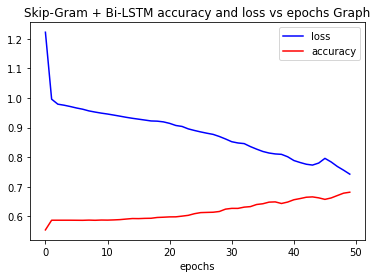

In [23]:
plt.title("Skip-Gram + Bi-LSTM accuracy and loss vs epochs Graph")
plt.plot(history_sg_bi.history['loss'],c='b',label='loss')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()

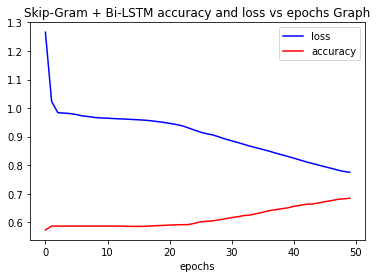

In [24]:
plt.title("Skip-Gram + Bi-LSTM accuracy and loss vs epochs Graph")
plt.plot(history_sg_LSTM.history['loss'],c='b',label='loss')
plt.plot(history_sg_LSTM.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()

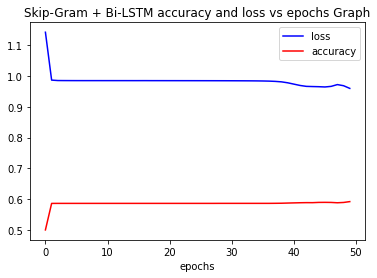

In [25]:
plt.title("Skip-Gram + Bi-LSTM accuracy and loss vs epochs Graph")
plt.plot(history_sg_rnn.history['loss'],c='b',label='loss')
plt.plot(history_sg_rnn.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()

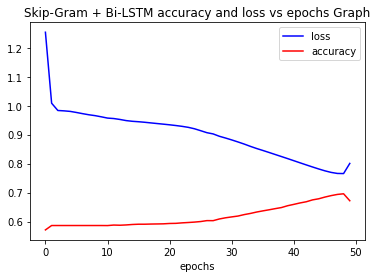

In [26]:
plt.title("Skip-Gram + Bi-LSTM accuracy and loss vs epochs Graph")
plt.plot(history_cbow_LSTM.history['loss'],c='b',label='loss')
plt.plot(history_cbow_LSTM.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()

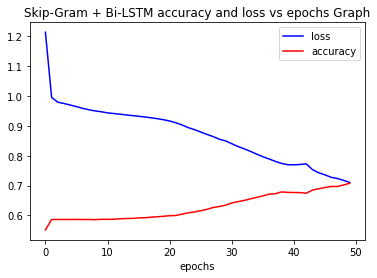

In [27]:
plt.title("Skip-Gram + Bi-LSTM accuracy and loss vs epochs Graph")
plt.plot(history_cbow_bi.history['loss'],c='b',label='loss')
plt.plot(history_cbow_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()

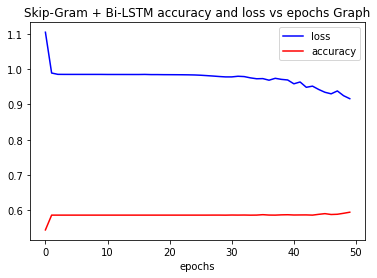

In [28]:
plt.title("Skip-Gram + Bi-LSTM accuracy and loss vs epochs Graph")
plt.plot(history_cbow_rnn.history['loss'],c='b',label='loss')
plt.plot(history_cbow_rnn.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()

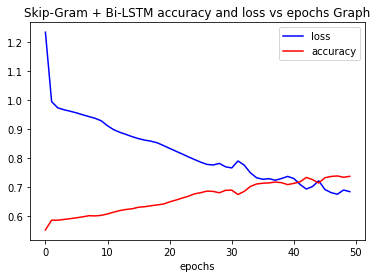

In [29]:
plt.title("Skip-Gram + Bi-LSTM accuracy and loss vs epochs Graph")
plt.plot(history_glove_LSTM.history['loss'],c='b',label='loss')
plt.plot(history_glove_LSTM.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()

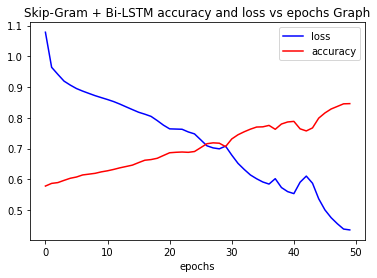

In [30]:
plt.title("Skip-Gram + Bi-LSTM accuracy and loss vs epochs Graph")
plt.plot(history_glove_bi.history['loss'],c='b',label='loss')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()

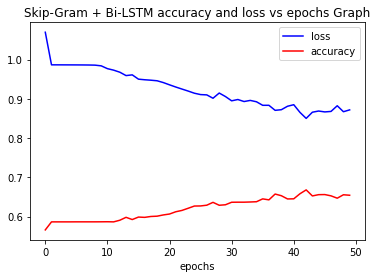

In [31]:
plt.title("Skip-Gram + Bi-LSTM accuracy and loss vs epochs Graph")
plt.plot(history_glove_rnn.history['loss'],c='b',label='loss')
plt.plot(history_glove_rnn.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()